In [82]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import time
import torchvision
from torchvision import transforms
from torchvision import datasets
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available:
    device_name = torch.cuda.get_device_name(0)
    print(device_name)
print(f"Using device: {device}")

NVIDIA GeForce RTX 4050 Laptop GPU
Using device: cuda:0


In [83]:
# Load and transform the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the images
])

# Preprocessing
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [90]:
# Define Model
class CNN1(nn.Module):
    def __init__(self, n_chans1=16, ):
        super(CNN1, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 * 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans1 * 2 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1 * 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

class CNN2(nn.Module):
    def __init__(self, n_chans1=16):
        super(CNN2, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 * 2, n_chans1 * 2 , kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans1 * 2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, self.n_chans1 * 2 * 4 * 4)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out



In [85]:
def train_model(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, patience=300):
    train_losses = []
    val_losses = []
    true_labels = []
    predicted_labels = []

    min_val_loss = float('inf')
    epochs_no_improve = 0
        
    for epoch in range(1, n_epochs +1):
        model.train()   # place model in train mode
        total_train_loss = 0.0
        # Load inputs and targets from train loader and move to device
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)    
            
            # train model
            train = model(inputs)
            loss_train = loss_fn(train, targets)

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            total_train_loss += loss_train.item()
        avg_train_loss = total_train_loss/ len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()    # place model into evaluation mode
        total_val_loss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, targets in val_loader: 
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)   
                
                # evaluate model
                val = model(inputs)
                loss_val = loss_fn(val, targets)
                # collect data
                total_val_loss += loss_val.item()
                _, predicted = torch.max(val, 1)
                true_labels.extend(targets.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Check if validation loss improved
        if val_losses[-1] < min_val_loss:
            min_val_loss = val_losses[-1]
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        # Early stopping check
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch} epochs!')
            break

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch} / {n_epochs}, Training loss {avg_train_loss:.4f},"f" Validation loss {avg_val_loss:.4f}")
    
    # Calculate metrics
    print("Metrics for Validation")
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
   
    return accuracy, precision, recall, f1, train_losses, val_losses, true_labels, predicted_labels



In [101]:
#PROBLEM 1a

# Instantiate model
model1 = CNN1().to(device, non_blocking=True)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

# Training and Validation in main loop

accuracy1, precision1, recall1, f11, train_losses1, val_losses1, true_labels1, predicted_labels1 = train_model(
    n_epochs = n_epochs,
    optimizer = optimizer1,
    model = model1,
    loss_fn = loss_fn, 
    train_loader = train_loader,
    val_loader=val_loader
    )

Epoch 1 / 300, Training loss 2.2678, Validation loss 2.2301
Epoch 10 / 300, Training loss 1.8291, Validation loss 1.8118
Epoch 20 / 300, Training loss 1.6002, Validation loss 1.5876
Epoch 30 / 300, Training loss 1.4788, Validation loss 1.4720
Epoch 40 / 300, Training loss 1.3893, Validation loss 1.3875
Epoch 50 / 300, Training loss 1.3084, Validation loss 1.3132
Epoch 60 / 300, Training loss 1.2396, Validation loss 1.2516
Epoch 70 / 300, Training loss 1.1809, Validation loss 1.2000
Epoch 80 / 300, Training loss 1.1306, Validation loss 1.1549
Epoch 90 / 300, Training loss 1.0862, Validation loss 1.1188
Epoch 100 / 300, Training loss 1.0470, Validation loss 1.0897
Epoch 110 / 300, Training loss 1.0107, Validation loss 1.0595
Epoch 120 / 300, Training loss 0.9771, Validation loss 1.0352
Epoch 130 / 300, Training loss 0.9457, Validation loss 1.0108
Epoch 140 / 300, Training loss 0.9152, Validation loss 0.9909
Epoch 150 / 300, Training loss 0.8873, Validation loss 0.9711
Epoch 160 / 300, Tr

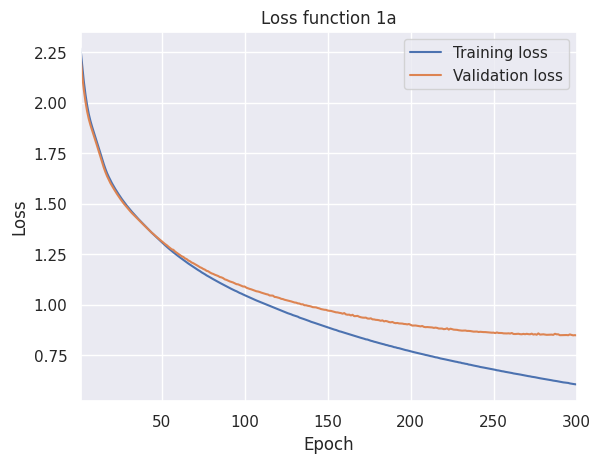

Text(0.5, 427.9555555555555, 'Predicted label')

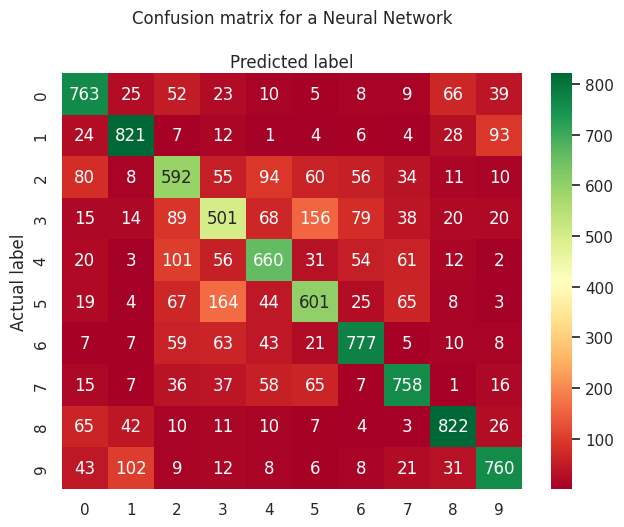

In [106]:
#Plot loss over epoch
fig1, ax = plt.subplots()
ax.plot(range(1, len(train_losses1) + 1), train_losses1, label='Training loss')
ax.plot(range(1, len(val_losses1) + 1), val_losses1, label='Validation loss')
ax.legend()
ax.set_title('Loss function 1a')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(1,n_epochs)
plt.show()

cnf_matrix = confusion_matrix(true_labels1, predicted_labels1)
sns.set()
class_names=['Down','Up'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 1a', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [104]:
# Problem 1b

# Instantiate model
model2 = CNN2().to(device=device, non_blocking=True)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

accuracy2, precision2, recall2, f12, train_losses2, val_losses2, true_labels2, predicted_labels2 = train_model(
    n_epochs = n_epochs,
    optimizer = optimizer2,
    model = model2,
    loss_fn = loss_fn, 
    train_loader = train_loader,
    val_loader=val_loader
)


Epoch 1 / 300, Training loss 2.3066, Validation loss 2.3027
Epoch 10 / 300, Training loss 2.0636, Validation loss 2.0424
Epoch 20 / 300, Training loss 1.8445, Validation loss 1.8211
Epoch 30 / 300, Training loss 1.6614, Validation loss 1.6420
Epoch 40 / 300, Training loss 1.5635, Validation loss 1.5501
Epoch 50 / 300, Training loss 1.4769, Validation loss 1.4671
Epoch 60 / 300, Training loss 1.3947, Validation loss 1.3905
Epoch 70 / 300, Training loss 1.3316, Validation loss 1.3326
Epoch 80 / 300, Training loss 1.2778, Validation loss 1.2806
Epoch 90 / 300, Training loss 1.2269, Validation loss 1.2338
Epoch 100 / 300, Training loss 1.1794, Validation loss 1.1887
Epoch 110 / 300, Training loss 1.1356, Validation loss 1.1480
Epoch 120 / 300, Training loss 1.0967, Validation loss 1.1138
Epoch 130 / 300, Training loss 1.0609, Validation loss 1.0830
Epoch 140 / 300, Training loss 1.0281, Validation loss 1.0530
Epoch 150 / 300, Training loss 0.9987, Validation loss 1.0280
Epoch 160 / 300, Tr

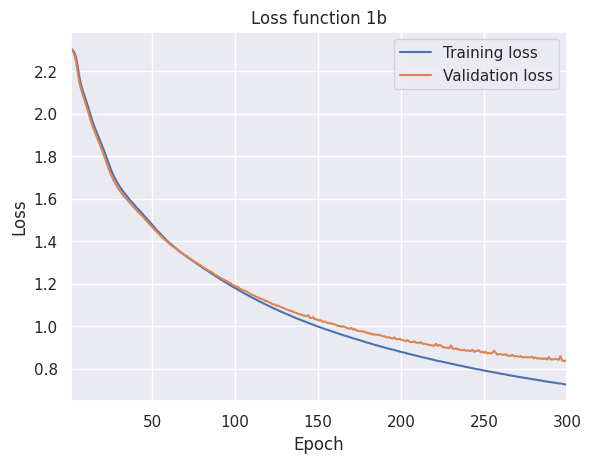

Text(0.5, 427.9555555555555, 'Predicted label')

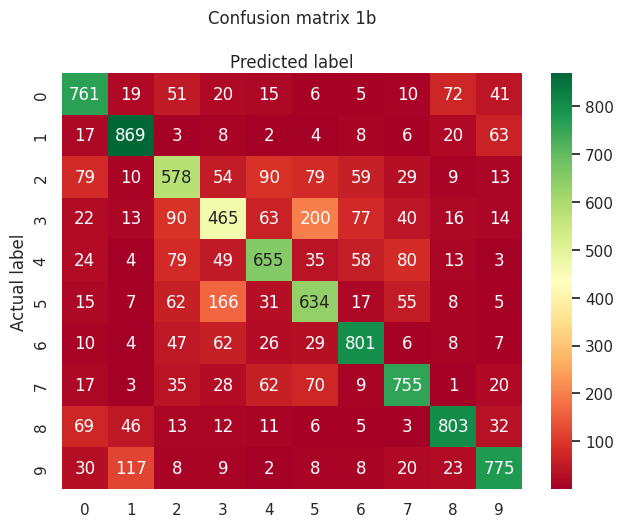

In [108]:
#Plot loss over epoch
fig1, ax = plt.subplots()
ax.plot(range(1, len(train_losses2) + 1), train_losses2, label='Training loss')
ax.plot(range(1, len(val_losses2) + 1), val_losses2, label='Validation loss')
ax.legend()
ax.set_title('Loss function 1b')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(1,n_epochs)
plt.show()

cnf_matrix = confusion_matrix(true_labels2, predicted_labels2)
sns.set()
class_names=['Down','Up'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 1b', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [114]:
#PROBLEM 2a

class ResBlock1(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock1, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(x)
        out = torch.relu(out)
        return out + x

# ResNet with 10 blocks
class ResNet10(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock1(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(n_chans1 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out 
    
# ResNet with 10 blocks
class ResNet10_1(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock2(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(n_chans1 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out 
    
# ResBlock with Norm, penalty, dropout
class ResBlock2(nn.Module):
    def __init__(self, n_chans, dropout_rate=0.3):
        super(ResBlock2, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.droput = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.droput(out)
        return out + x

In [109]:
# Instantiate the model 
model3 = ResNet10().to(device=device, non_blocking=True)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

# Train and validate the model
accuracy, precision3, recall3, f13, train_losses3, val_losses3, true_labels3, predicted_labels3 = train_model(
    n_epochs = n_epochs,
    optimizer = optimizer3,
    model = model3,
    loss_fn = loss_fn, 
    train_loader = train_loader,
    val_loader=val_loader
)


Epoch 1 / 300, Training loss 1.9051, Validation loss 1.7551
Epoch 10 / 300, Training loss 1.0613, Validation loss 1.1778
Epoch 20 / 300, Training loss 0.8366, Validation loss 0.9896
Epoch 30 / 300, Training loss 0.7012, Validation loss 1.0246
Epoch 40 / 300, Training loss 0.5965, Validation loss 1.0546
Epoch 50 / 300, Training loss 0.5092, Validation loss 1.3315
Epoch 60 / 300, Training loss 0.4311, Validation loss 1.4589
Epoch 70 / 300, Training loss 0.3670, Validation loss 1.3899
Epoch 80 / 300, Training loss 0.3018, Validation loss 1.8862
Epoch 90 / 300, Training loss 0.2550, Validation loss 2.2429
Epoch 100 / 300, Training loss 0.2233, Validation loss 2.2551
Epoch 110 / 300, Training loss 0.1925, Validation loss 2.3586
Epoch 120 / 300, Training loss 0.1684, Validation loss 2.6968
Epoch 130 / 300, Training loss 0.1424, Validation loss 5.4054
Epoch 140 / 300, Training loss 0.1100, Validation loss 3.0530
Epoch 150 / 300, Training loss 0.0822, Validation loss 3.6283
Epoch 160 / 300, Tr

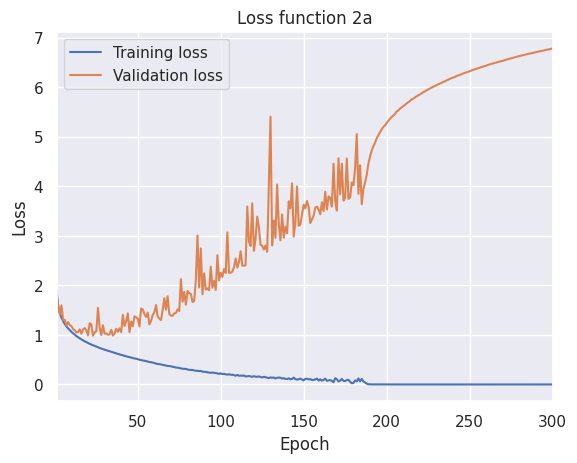

Text(0.5, 427.9555555555555, 'Predicted label')

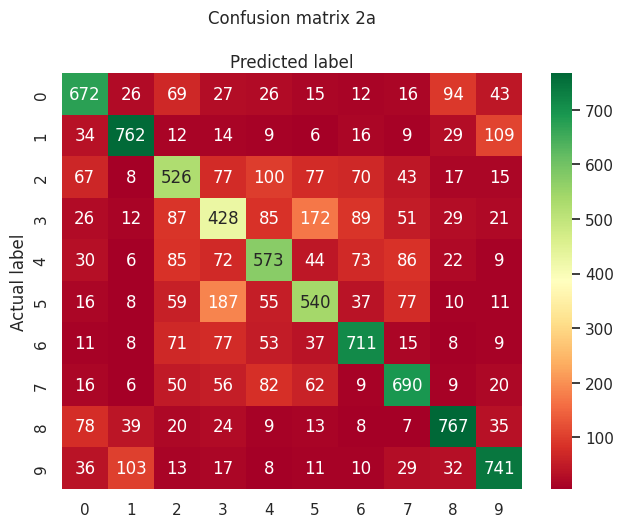

In [112]:
#Plot loss over epoch
fig1, ax = plt.subplots()
ax.plot(range(1, len(train_losses3) + 1), train_losses3, label='Training loss')
ax.plot(range(1, len(val_losses3) + 1), val_losses3, label='Validation loss')
ax.legend()
ax.set_title('Loss function 2a')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(1,n_epochs)
plt.show()

cnf_matrix = confusion_matrix(true_labels3, predicted_labels3)
sns.set()
class_names=['Down','Up'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 2a', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [119]:
# PROBLEM 2b
model4 = ResNet10_1().to(device=device, non_blocking=True)
optimizer4 = optim.SGD(model4.parameters(), lr=3e-3, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 300

accuracy4, precision4, recall4, f14, train_losses4, val_losses4, true_labels4, predicted_labels4 = train_losses = train_model(
    n_epochs = n_epochs,
    optimizer = optimizer4,
    model = model4,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)


Epoch 1 / 300, Training loss 1.8756, Validation loss 3.2132
Epoch 10 / 300, Training loss 0.9679, Validation loss 3.7457
Epoch 20 / 300, Training loss 0.7705, Validation loss 4.3815
Epoch 30 / 300, Training loss 0.6768, Validation loss 5.7795
Epoch 40 / 300, Training loss 0.6078, Validation loss 5.6201
Epoch 50 / 300, Training loss 0.5571, Validation loss 6.1141
Epoch 60 / 300, Training loss 0.5120, Validation loss 6.1155
Epoch 70 / 300, Training loss 0.4777, Validation loss 6.6816
Epoch 80 / 300, Training loss 0.4419, Validation loss 6.1111
Epoch 90 / 300, Training loss 0.4162, Validation loss 7.2706
Epoch 100 / 300, Training loss 0.3893, Validation loss 4.9510
Epoch 110 / 300, Training loss 0.3627, Validation loss 5.5900
Epoch 120 / 300, Training loss 0.3448, Validation loss 5.3297
Epoch 130 / 300, Training loss 0.3236, Validation loss 6.2235
Epoch 140 / 300, Training loss 0.3033, Validation loss 4.7289
Epoch 150 / 300, Training loss 0.2858, Validation loss 5.0590
Epoch 160 / 300, Tr

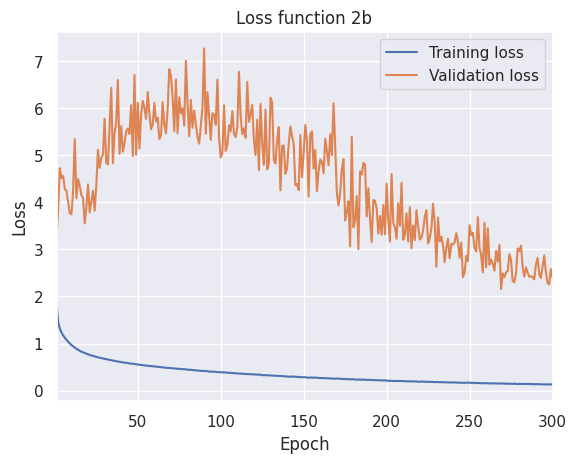

Text(0.5, 427.9555555555555, 'Predicted label')

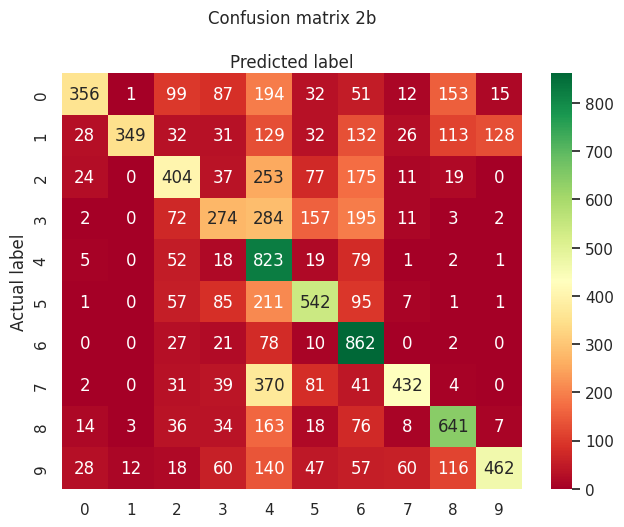

In [120]:
#Plot loss over epoch
fig1, ax = plt.subplots()
ax.plot(range(1, len(train_losses4) + 1), train_losses4, label='Training loss')
ax.plot(range(1, len(val_losses4) + 1), val_losses4, label='Validation loss')
ax.legend()
ax.set_title('Loss function 2b')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim(1,n_epochs)
plt.show()

cnf_matrix = confusion_matrix(true_labels4, predicted_labels4)
sns.set()
class_names=['Down','Up'] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="RdYlGn" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix 2b', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

